In [1]:
import pandas as pd
import numpy as np
import math
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
from natsort import natsorted
from skimage import io
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import itertools
import cv2 as cv
import h5py
from PIL import Image


Paths are for dataset tagged: all


In [2]:
# read through each metadata file and fix framestamp rollover
metadata_file = glob.glob(os.path.join(paths['raw_data'],'session*.csv'))
print(metadata_file)

numFrames = np.zeros(len(metadata_file))
time = []
framestamp = []
Frames = []
for i in range(len(metadata_file)):
    metadata = pd.read_csv(metadata_file[i])
    numFrames[i] = len(metadata.Width)
    numFrames[i] = numFrames[i].astype(int)
    timestamp = metadata.CameraTimestampSeconds + 10**-6*metadata.CameraTimestampMicroSeconds
    time.append(timestamp)

    framestamp = metadata.Framestamp
    framestamp = np.array(framestamp)
    bitmax = np.where(framestamp == 65535)
    if len(bitmax[0]) == 1:
        cut = framestamp[bitmax[0][0]+1:-1]
        newcut = cut + 65535
        Frames.append(np.concatenate((framestamp[0:bitmax[0][0]],newcut)))
    elif len(bitmax[0]) > 1:
        temp = []
        temp.append(np.array(framestamp[0:bitmax[0][0]]))
        for j in range(len(bitmax[0])-1):
            cut = temp[j][-1] + framestamp[bitmax[0][j]+1:bitmax[0][j+1]]
            temp.append(cut)
        temp.append(temp[j+1][-1] + framestamp[bitmax[0][-1]+1:-1])
        Frames.append(np.concatenate(temp))
    elif len(bitmax[0]) == 0:
        Frames.append(framestamp[0:-1])

width = metadata.Width[0]
print(width)
Xoffset = metadata.XOffset[0]
Xoffset = Xoffset.astype(int)
print(Xoffset)
height = metadata.Height[0]
print(height)
Yoffset = metadata.YOffset[0]
Yoffset = Yoffset.astype(int)
print(Yoffset)

['C:\\AIND\\output_data\\BigTiffs2024-11-26T11_37_05.0625152-08_00\\session_params_2024-11-26T11_37_05.csv', 'C:\\AIND\\output_data\\BigTiffs2024-11-26T11_37_05.0625152-08_00\\session_params_2024-11-26T11_45_33.csv', 'C:\\AIND\\output_data\\BigTiffs2024-11-26T11_37_05.0625152-08_00\\session_params_2024-11-26T11_51_36.csv', 'C:\\AIND\\output_data\\BigTiffs2024-11-26T11_37_05.0625152-08_00\\session_params_2024-11-26T11_55_47.csv', 'C:\\AIND\\output_data\\BigTiffs2024-11-26T11_37_05.0625152-08_00\\session_params_2024-11-26T11_59_22.csv', 'C:\\AIND\\output_data\\BigTiffs2024-11-26T11_37_05.0625152-08_00\\session_params_2024-11-26T12_01_46.csv']
1460
520
204
524


In [3]:
# Unskew image, rotation followed by affine transformation

# Read from calibration.txt
with open(paths['raw_data'] / 'calibration.txt', 'r') as f:
    for line in f:
        name, value = line.strip().split(' = ')
        exec(f'{name} = {value}')

# Read from above txt file after running preprocess_01_unskewimage
theta_r = rot_tform_thetaR
pt1 = [aff_tform_pt1[0]-Xoffset, aff_tform_pt1[1]-Yoffset] 
pt2 = [aff_tform_pt2[0]-Xoffset, aff_tform_pt2[1]-Yoffset] 
pt3 = [aff_tform_pt3[0]-Xoffset, aff_tform_pt3[1]-Yoffset] 
pt4 = [aff_tform_pt4[0]-Xoffset, aff_tform_pt4[1]-Yoffset] 
pt5 = [aff_tform_pt5[0]-Xoffset, aff_tform_pt5[1]-Yoffset] 
pt6 = [aff_tform_pt6[0]-Xoffset, aff_tform_pt6[1]-Yoffset]
fiber1_location = [fiber1_pixels[1]-Yoffset,fiber1_pixels[0]-Yoffset]
fiber2_location = [fiber2_pixels[1]-Yoffset,fiber2_pixels[0]-Yoffset]

fiber1_location = [int(x) for x in fiber1_location]
fiber2_location = [int(x) for x in fiber2_location]

# Create rotation and affine transformation matrix
rows,cols = [height, width]
M1 = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),theta_r,1)
pts1 = np.float32([pt1, pt2, pt3])
pts2 = np.float32([pt4, pt5, pt6])
M2 = cv.getAffineTransform(pts1,pts2)

In [4]:
# Get all Tiff directories
files = os.listdir(paths['raw_data'])
print(files)
folders = []
for entry in os.scandir(paths['raw_data']):
    if entry.is_dir():
        folders.append(entry.name)
folders = natsorted(folders)
print(folders)

# Read through each Tiff directory, exrtact tiff files, and unskew images
fiber1 = []
fiber2 = []
peaks = []
tiffbatch = 1000
for i in range(len(folders)):
    print(folders[i])
    files = os.listdir(os.path.join(paths['raw_data'],folders[i]))
    files = natsorted(files)
    num_files = np.size(files,0)
    tiff_file_path = os.path.join(paths['raw_data'],folders[i],files[0])
    temp = io.imread(tiff_file_path).astype(float)
    num = len(files) #int(''.join(filter(str.isdigit, files[-1])))
    lenToUse = min(num,math.floor(len(time[i])/1000)) #Changed for ocamp testing 2024_08_05
    sz_x = tiffbatch*lenToUse
    sz_y = width
    tempfiber1 = np.zeros([sz_x, sz_y])
    tempfiber2 = np.zeros([sz_x, sz_y])
    peak = np.zeros(sz_x)
    for j in range(lenToUse):
    # for j in range(num_files-1):
        print(files[j])
        # Extract the number in the filename and convert to integer
        num = int(''.join(filter(str.isdigit, files[j])))
        tiff_file_path = os.path.join(paths['raw_data'],folders[i],files[j])
        temp = io.imread(tiff_file_path).astype(float)
        # background = np.mean(temp[:,0:20,0:200]) # Top corner left pixels are used for background subtraction
        for frame in range(temp.shape[0]):
            temp_rotated = cv.warpAffine(temp[frame,:,:],M1,(cols,rows))
            img = cv.warpAffine(temp_rotated,M2,(cols,rows))
            img = img #- background
            fiber1_m = np.mean(img[fiber1_location[1]:fiber1_location[0],:],axis=0)
            fiber2_m = np.mean(img[fiber2_location[1]:fiber2_location[0],:],axis=0)
            
            # # Use if running mouse
            temp_peak, _ = find_peaks(fiber1_m,height=200,distance=200)
            if len(temp_peak) > 1:
                max_peak = np.argmax(fiber1_m[temp_peak])
                temp_peak = temp_peak[max_peak]

            # Use if running mouse with tdTomato
            # idx = np.where(fiber2_m > 300)
            # idx = idx[0][-1]
            # temp_peak = idx

            # # Use if running slide imaging
            # idx = np.where(fiber1_m > 10000)
            # idx = idx[0][-1]
            # temp_peak = idx

            fiber1_m = np.expand_dims(fiber1_m, axis=0)
            fiber2_m = np.expand_dims(fiber2_m, axis=0)
            if j == 0:
                tempfiber1[frame,:] = fiber1_m
                tempfiber2[frame,:] = fiber2_m
                peak[frame] = temp_peak
            else:
                tempfiber1[num*tiffbatch + frame,:] = fiber1_m
                tempfiber2[num*tiffbatch + frame,:] = fiber2_m
                peak[num*tiffbatch + frame] = temp_peak

    fiber1.append(tempfiber1)
    fiber2.append(tempfiber2)
    peaks.append(peak)

# Truncate time vectors to match the length of tiff files
for i in range(len(time)):
    if time[i].shape > fiber1[i].shape:
        time[i] = time[i][0:fiber1[i].shape[0]]

['calibration.txt', 'CalibrationImage.tiff', 'pixel_to_nm.hdf5', 'session_params_2024-11-26T11_37_05.csv', 'session_params_2024-11-26T11_45_33.csv', 'session_params_2024-11-26T11_51_36.csv', 'session_params_2024-11-26T11_55_47.csv', 'session_params_2024-11-26T11_59_22.csv', 'session_params_2024-11-26T12_01_46.csv', 'Tiffs1', 'Tiffs2', 'Tiffs3', 'Tiffs4', 'Tiffs5', 'Tiffs6', 'TTL_2024-11-26T11_37_05.0635776-08_00', 'TTL_2024-11-26T11_45_33.1507328-08_00', 'TTL_2024-11-26T11_51_36.5626880-08_00', 'TTL_2024-11-26T11_55_48.1676672-08_00', 'TTL_2024-11-26T11_59_22.3848704-08_00', 'TTL_2024-11-26T12_01_46.7729152-08_00', 'TTL_TS_2024-11-26T11_37_05.csv', 'TTL_TS_2024-11-26T11_45_33.csv', 'TTL_TS_2024-11-26T11_51_36.csv', 'TTL_TS_2024-11-26T11_55_47.csv', 'TTL_TS_2024-11-26T11_59_22.csv', 'TTL_TS_2024-11-26T12_01_46.csv']
['Tiffs1', 'Tiffs2', 'Tiffs3', 'Tiffs4', 'Tiffs5', 'Tiffs6']
Tiffs1
Tiffs0.tif
Tiffs1.tif
Tiffs2.tif
Tiffs3.tif
Tiffs4.tif
Tiffs5.tif
Tiffs6.tif
Tiffs7.tif
Tiffs8.tif
Tiffs9

[array([405., 445., 473., ..., 473., 514., 560.]), array([514., 560., 405., ..., 405., 445., 473.]), array([560., 405., 445., ..., 445., 473., 514.]), array([514., 560., 405., ..., 405., 445., 473.]), array([445., 473., 514., ..., 514., 560., 405.]), array([514., 560., 405., ..., 405., 445., 473.])]


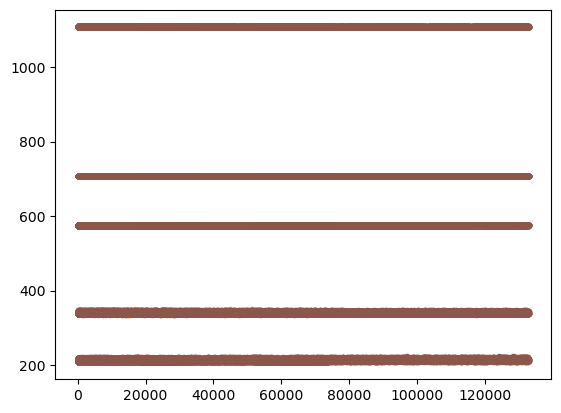

In [5]:
# Set order of lasers and interleave into individual laser channels

c = pd.read_hdf(paths['raw_data']/'pixel_to_nm.hdf5', key='Camera_pixel', more='r')
w = pd.read_hdf(paths['raw_data']/'pixel_to_nm.hdf5', key='Wavelength_nm', more='r')
wavelength = w.to_numpy()
camera_px = c.to_numpy()
lasers = [405,445,473,514,560]

laser_order = []
for i in range(len(peaks)):
    l_order = np.zeros(len(peaks[i]))
    for j in range(len(peaks[i])):
        laser_pix = min(camera_px, key=lambda x:abs(x-peaks[i][j]-Xoffset))
        camera_pix = np.where(camera_px>=laser_pix)
        p = camera_pix[-1]
        p = p[-1]
        temp_laser = min(lasers, key=lambda x:abs(x-wavelength[p]))
        l_order[j] = temp_laser
    laser_order.append(l_order)
print(laser_order)

# Plot the peaks to check if the laser order is correct
for i in range(len(peaks)):
    plt.plot(peaks[i],'.')
plt.show()


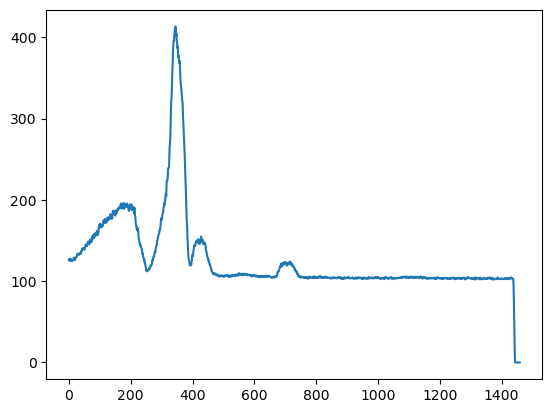

In [6]:
# Find where laser order is 560

# for i in range(len(laser_order)):
#     idx = np.where(laser_order[i] == 560)
#     idx = idx[0]
#     print(idx)
#     print(len(idx))

# Plot fiber1
plt.figure()
plt.plot(fiber2[0][3,:])
plt.show()

In [7]:
# Interleave signals from each fiber into the five laser channels
L405_F1 = []
L445_F1 = []
L473_F1 = []
L514_F1 = []
L560_F1 = []
L405_F2 = []
L445_F2 = []
L473_F2 = []
L514_F2 = []
L560_F2 = []
time_405 = []
time_445 = []
time_473 = []
time_514 = []
time_560 = []

for i in range(len(folders)):
    L405_idx = np.where(laser_order[i]==405)
    L405_idx = np.array(L405_idx[0])
    F1_405 = fiber1[i][L405_idx,:]
    F2_405 = fiber2[i][L405_idx,:]
    temptime_405 = np.array(time[i][L405_idx])
    L445_idx = np.where(laser_order[i]==445)
    L445_idx = np.array(L445_idx[0])
    F1_445 = fiber1[i][L445_idx,:]
    F2_445 = fiber2[i][L445_idx,:]
    temptime_445 = np.array(time[i][L445_idx])
    L473_idx = np.where(laser_order[i]==473)
    L473_idx = np.array(L473_idx[0])
    F1_473 = fiber1[i][L473_idx,:]
    F2_473 = fiber2[i][L473_idx,:]
    temptime_473 = np.array(time[i][L473_idx])
    L514_idx = np.where(laser_order[i]==514)
    L514_idx = np.array(L514_idx[0])
    F1_514 = fiber1[i][L514_idx,:]
    F2_514 = fiber2[i][L514_idx,:]
    temptime_514 = np.array(time[i][L514_idx])
    L560_idx = np.where(laser_order[i]==560)
    L560_idx = np.array(L560_idx[0])
    F1_560 = fiber1[i][L560_idx,:]
    F2_560 = fiber2[i][L560_idx,:]
    temptime_560 = np.array(time[i][L560_idx])
    
    L405_F1.append(F1_405)
    L445_F1.append(F1_445)
    L473_F1.append(F1_473)
    L514_F1.append(F1_514)
    L560_F1.append(F1_560)
    L405_F2.append(F2_405)
    L445_F2.append(F2_445)
    L473_F2.append(F2_473)
    L514_F2.append(F2_514)
    L560_F2.append(F2_560)
    time_405.append(temptime_405)
    time_445.append(temptime_445)
    time_473.append(temptime_473)
    time_514.append(temptime_514)
    time_560.append(temptime_560)

In [8]:
# Concatenate signals from all frame folders into a single sequence
LCh405_F1 = np.concatenate(L405_F1)
LCh445_F1 = np.concatenate(L445_F1)
LCh473_F1 = np.concatenate(L473_F1)
LCh514_F1 = np.concatenate(L514_F1)
LCh560_F1 = np.concatenate(L560_F1)
LCh405_F2 = np.concatenate(L405_F2)
LCh445_F2 = np.concatenate(L445_F2)
LCh473_F2 = np.concatenate(L473_F2)
LCh514_F2 = np.concatenate(L514_F2)
LCh560_F2 = np.concatenate(L560_F2)
lasers = np.concatenate(laser_order)
timeseries_405 = np.concatenate(time_405)
timeseries_445 = np.concatenate(time_445)
timeseries_473 = np.concatenate(time_473)
timeseries_514 = np.concatenate(time_514)
timeseries_560 = np.concatenate(time_560)
full_time = np.concatenate(time)

In [9]:
# Convert pixel data into wavelength data

LCh_405_F1 = np.zeros([LCh405_F1.shape[0], wavelength.shape[0]])
LCh_405_F2 = np.zeros([LCh405_F2.shape[0], wavelength.shape[0]])
LCh_445_F1 = np.zeros([LCh445_F1.shape[0], wavelength.shape[0]])
LCh_445_F2 = np.zeros([LCh445_F2.shape[0], wavelength.shape[0]])
LCh_473_F1 = np.zeros([LCh473_F1.shape[0], wavelength.shape[0]])
LCh_473_F2 = np.zeros([LCh473_F2.shape[0], wavelength.shape[0]])
LCh_514_F1 = np.zeros([LCh514_F1.shape[0], wavelength.shape[0]])
LCh_514_F2 = np.zeros([LCh514_F2.shape[0], wavelength.shape[0]])
LCh_560_F1 = np.zeros([LCh560_F1.shape[0], wavelength.shape[0]])
LCh_560_F2 = np.zeros([LCh560_F2.shape[0], wavelength.shape[0]])

for px in range(0,wavelength.shape[0]):
    LCh_405_F1[:,px] = LCh405_F1[:,camera_px[px]-Xoffset]
    LCh_405_F2[:,px] = LCh405_F2[:,camera_px[px]-Xoffset]
    LCh_445_F1[:,px] = LCh445_F1[:,camera_px[px]-Xoffset]
    LCh_445_F2[:,px] = LCh445_F2[:,camera_px[px]-Xoffset]
    LCh_473_F1[:,px] = LCh473_F1[:,camera_px[px]-Xoffset]
    LCh_473_F2[:,px] = LCh473_F2[:,camera_px[px]-Xoffset]
    LCh_514_F1[:,px] = LCh514_F1[:,camera_px[px]-Xoffset]
    LCh_514_F2[:,px] = LCh514_F2[:,camera_px[px]-Xoffset]
    LCh_560_F1[:,px] = LCh560_F1[:,camera_px[px]-Xoffset]
    LCh_560_F2[:,px] = LCh560_F2[:,camera_px[px]-Xoffset]
    

In [10]:
# Regress laser noise from 445 and 473 channels

# High pass filter the signal
# Scale noise linearly to signal 
# Subtract scaled noise from signal
# Add signal back to low frequency component of original signal

from scipy import signal

def butter_highpass(cutoff, fs, order=1):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=1):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Low pass filter the signal
fps = 150.25/5 # 24 for pre-2024
noise_px = 473
pass_freq = 5

def denoise_signal(sig, noise_px, pass_freq, fps):
    new_sig = np.zeros(sig.shape)
    for i in range(0,len(sig[0,:])):
        lowfilt_sig = butter_lowpass_filter(sig[:,i],pass_freq,fps)
        noise = sig[:,noise_px-400]
        A = np.vstack([noise, np.ones(len(noise))]).T
        [x,y] = np.linalg.lstsq(A, lowfilt_sig, rcond=None)[0]
        scl_noise = x*noise + y
        final_sig = lowfilt_sig - scl_noise + np.mean(lowfilt_sig)
        new_sig[:,i] = final_sig
    return new_sig

# noise_px = 445
# denoised_signal_445_F1 = denoise_signal(LCh_445_F1, noise_px, pass_freq, fps)
# denoised_signal_445_F2 = denoise_signal(LCh_445_F2, noise_px, pass_freq, fps)
# noise_px = 473
# denoised_signal_473_F1 = denoise_signal(LCh_473_F1, noise_px, pass_freq, fps)
# denoised_signal_473_F2 = denoise_signal(LCh_473_F2, noise_px, pass_freq, fps)

# Low pass filter the other signals

def lowpass_signal(sig, pass_freq, fps):
    new_sig = np.zeros(sig.shape)
    for i in range(0,len(sig[0,:])):
        lowfilt_sig = butter_lowpass_filter(sig[:,i],pass_freq,fps)
        new_sig[:,i] = lowfilt_sig
    return new_sig

pass_freq = 5
filtered_405_F1 = lowpass_signal(LCh_405_F1,pass_freq,fps)
filtered_405_F2 = lowpass_signal(LCh_405_F2,pass_freq,fps)
filtered_445_F1 = lowpass_signal(LCh_445_F1,pass_freq,fps)
filtered_445_F2 = lowpass_signal(LCh_445_F2,pass_freq,fps)
filtered_473_F1 = lowpass_signal(LCh_473_F1,pass_freq,fps)
filtered_473_F2 = lowpass_signal(LCh_473_F2,pass_freq,fps)
filtered_514_F1 = lowpass_signal(LCh_514_F1,pass_freq,fps)
filtered_514_F2 = lowpass_signal(LCh_514_F2,pass_freq,fps)
filtered_560_F1 = lowpass_signal(LCh_560_F1,pass_freq,fps)
filtered_560_F2 = lowpass_signal(LCh_560_F2,pass_freq,fps)

LCh_405_F1 = filtered_405_F1
LCh_405_F2 = filtered_405_F2
LCh_445_F1 = filtered_445_F1
LCh_445_F2 = filtered_445_F2
LCh_473_F1 = filtered_473_F1
LCh_473_F2 = filtered_473_F2
LCh_514_F1 = filtered_514_F1
LCh_514_F2 = filtered_514_F2
LCh_560_F1 = filtered_560_F1
LCh_560_F2 = filtered_560_F2


In [11]:
# Save preprocessed data in hdf5 file

data_preprocessed = {'Time_405':timeseries_405, 'Time_445':timeseries_445, 'Time_473':timeseries_473, 'Time_514':timeseries_514, 
                        'Time_560':timeseries_560, 'Full_TimeStamps':full_time,'Lasers':lasers, 'Wavelength':wavelength, 
                        'Channel_405_F1':LCh_405_F1, 'Channel_445_F1':LCh_445_F1, 'Channel_473_F1':LCh_473_F1,
                        'Channel_514_F1':LCh_514_F1, 'Channel_560_F1':LCh_560_F1, 'Channel_405_F2':LCh_405_F2,
                        'Channel_445_F2':LCh_445_F2, 'Channel_473_F2':LCh_473_F2, 'Channel_514_F2':LCh_514_F2,
                        'Channel_560_F2':LCh_560_F2}
for key in data_preprocessed.keys():
    print(f'\n{key}')
    print(data_preprocessed[key])

# Write a new hdf5 file with all keys in data_preprocessed
hf = h5py.File(paths['raw_data'] / 'hsfp_data_preprocessed.hdf5','w')
for key in data_preprocessed.keys():
    hf.create_dataset(key, data = data_preprocessed[key])
hf.close()


Time_405
[1.73264983e+09 1.73264983e+09 1.73264983e+09 ... 1.73265220e+09
 1.73265220e+09 1.73265220e+09]

Time_445
[1.73264983e+09 1.73264983e+09 1.73264983e+09 ... 1.73265220e+09
 1.73265220e+09 1.73265220e+09]

Time_473
[1.73264983e+09 1.73264983e+09 1.73264983e+09 ... 1.73265220e+09
 1.73265220e+09 1.73265220e+09]

Time_514
[1.73264983e+09 1.73264983e+09 1.73264983e+09 ... 1.73265220e+09
 1.73265220e+09 1.73265220e+09]

Time_560
[1.73264983e+09 1.73264983e+09 1.73264983e+09 ... 1.73265220e+09
 1.73265220e+09 1.73265220e+09]

Full_TimeStamps
[1.73264983e+09 1.73264983e+09 1.73264983e+09 ... 1.73265220e+09
 1.73265220e+09 1.73265220e+09]

Lasers
[405. 445. 473. ... 405. 445. 473.]

Wavelength
[400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453
 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471
 47

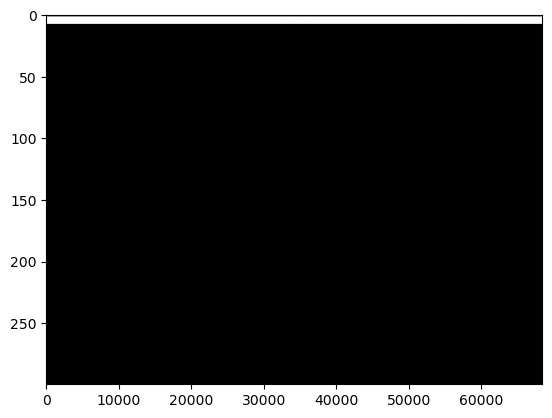

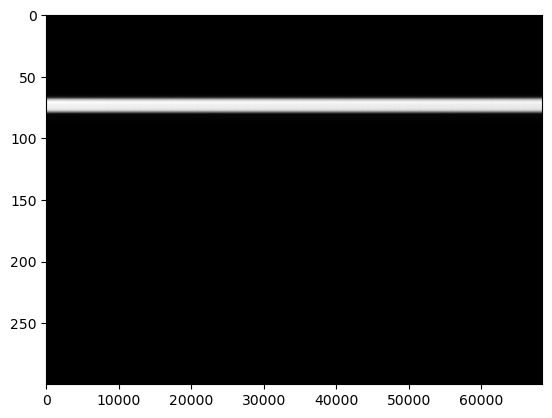

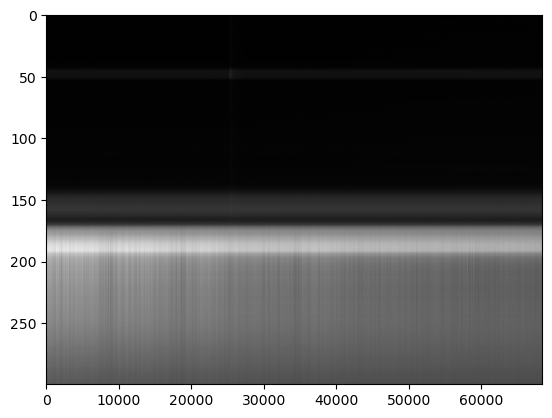

In [12]:
# Plot a spectrogram image of LCh473_F1 as a check

plt.figure()
plt.imshow(LCh_405_F2.T, aspect='auto', cmap='gray')
plt.show()

plt.figure()
plt.imshow(LCh_473_F2.T, aspect='auto', cmap='gray')
plt.show()

plt.figure()
plt.imshow(LCh_560_F2.T, aspect='auto', cmap='gray')
plt.show()